# Assignment 3 - Segmentation

You are expected to complete this notebook with lines of code, plots and texts. You will need to create new cells with original code or text for your analyses. This assignment has a total of 100 points and 5 questions.

Using Canvas, you will deliver the notebook file (.ipynb) with cells executed and outputs visible.
- You should use PyTorch 1.0 or later as your deep learning framework. If you need to import a different package than the ones already imported, ask the TA if you can do it.
- No other data than the dataset variables provided should be used, and training, validation and testing splits should be the same as the ones provided.
- The cell outputs present in your delivered notebook should be reproducible by us by running your notebook cells in order.
- All code must be your own work. Code cannot be copied from another source or student. You may copy code from cells that were pre-defined in this notebook if you think it is useful for use in another part of the notebook.
- All images must be generated from data generated in your code. Do NOT import/display images generated outside your code.
- Your analysis must be your own, but if you quote text or equations from another source make sure to cite the reference.
- It is assumed that PyTorch is already installed according to the CADE or the COLAB tutorial.
- For all analyses you write, in the case that you ran code to get to its conclusions, you should provide code that provides evidence for these conclusions. This code should print the numbers that are cited, or plot a graph, or print a table, or, even better, a combination of these. Do not erase or comment code and its outputs in the case you cite them in your analyses.
- You should provide evidence that your code satisfies all the constraints of the questions. For showing that numeric constraints are satisfied, provide some kind of printed number, and not only a graph.

Other notes:
- Cells should be run in order, using Shift+Enter.
- Read all the provided code cells and its comments, as it contains variables and information that you may need to use to complete the notebook.
- To create a text cell, create it with the "+" button and change its type from "Code" to "Markdown" using the top menu. To modify a text cell, double click on it.
- If you are interested, you can check detail on formatting markdown text here: https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed
- The accuracies provided as required for each question are there to make sure you work enough on each model to get a good result. Part of the grade is based on this.
- We assume a GPU of at least 4GB of memory is available. If you want to try running the assignment with a GPU that has less than that, you can try changing the argument passed when calling the ```define_gpu_to_use``` function.  If you are getting out-of-memory errors for the GPU, you may want to check what is occupying the GPU memory by using the command ```!nvidia-smi```, which gives a report of the use of the GPU. 
- A few PyTorch details to remember:
    - Remember to toggle train/eval mode for your model
    - Remember to reset the gradients with ```zero_grad()``` before each call to ```backward()```
    - Remember to check if the loss you are using receives logits or probabilities, and adapt your model output accordingly.
    - Remember to reinstantiate your model every time you are starting a new training, so that weights are reset.
    - Remember to pass to the optimizer the set of parameters for the model you want to train.

#### Initial setups

In [247]:
!pip3 install imageio
!pip3 install matplotlib
!pip3 install scikit-image
!pip3 install scikit-learn

You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [248]:
#importing the libraries used in the rest of hte code
import os
import gzip
import shutil
import tarfile
import imageio
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import zipfile
import collections
from skimage import morphology
from skimage.measure import block_reduce
import scipy
from torch.utils.data import Dataset
import PIL
from PIL import Image
from sklearn.metrics import f1_score
import copy
import random
import math
import torch

In [249]:
#checking what kind of system you are using
try:
  import google.colab
  from google.colab import drive
  from google.colab import files
  IN_COLAB = True
except:
  IN_COLAB = False
try:
    hostname = !hostname
    if 'lab' in hostname[0] and '.eng.utah.edu' in hostname[0]:
        IN_CADE = True
    else:
        IN_CADE = False
except:
    IN_CADE = False

assert(not IN_CADE or not IN_COLAB)

In [250]:
# with this function you set the value of the environment variable CUDA_VISIBLE_DEVICES
# to set which GPU to use
# it also reserves this amount of memory for your exclusive use. This might be important for 
# not having other people using the resources you need in shared systems
# the homework was tested in a GPU with 4GB of memory, and running this function will require at least
# as much
# if you want to test in a GPU with less memory, you can call this function
# with the argument minimum_memory_mb specifying how much memory from the GPU you want to reserve
def define_gpu_to_use(minimum_memory_mb = 3800):
    gpu_to_use = None
    try: 
        os.environ['CUDA_VISIBLE_DEVICES']
        print('GPU already assigned before: ' + str(os.environ['CUDA_VISIBLE_DEVICES']))
        return
    except:
        pass
    torch.cuda.empty_cache()
    for i in range(16):
        free_memory = !nvidia-smi --query-gpu=memory.free -i $i --format=csv,nounits,noheader
        if free_memory[0] == 'No devices were found':
            break
        free_memory = int(free_memory[0])
        if free_memory>minimum_memory_mb-500:
            gpu_to_use = i
            break
    if gpu_to_use is None:
        print('Could not find any GPU available with the required free memory of ' +str(minimum_memory_mb) + 'MB. Please use a different system for this assignment.')
    else:
        os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu_to_use)
        print('Chosen GPU: ' + str(gpu_to_use))
        x = torch.rand((256,1024,minimum_memory_mb-500)).cuda()
        x = torch.rand((1,1)).cuda()
        del x

In [251]:
if IN_CADE:
    #setting the gpu that will be used, testing if it has enough available memory, and reserving the needed memory
    define_gpu_to_use()

#### Defining functions used to load the dataset

We are going to use datasets of retinal digital images and segment the blood vessels from it. We are going to use the DRIVE dataset (https://www.isi.uu.nl/Research/Databases/DRIVE/) and the STARE dataset (http://cecas.clemson.edu/~ahoover/stare/) together in this assignment. We are going to use our own train/validation/test splits, even though the DRIVE dataset provides its own split. Please download the files named "DRIVE.zip" (register in https://www.isi.uu.nl/Research/Databases/DRIVE/download.php and follow the instructions), "stare-images.tar" (http://cecas.clemson.edu/~ahoover/stare/probing/stare-images.tar), "labels-vk.tar" (http://cecas.clemson.edu/~ahoover/stare/probing/labels-vk.tar) and put in the same folder as this notebook file so that the dataset can be loaded. 

The dataset also contains masks since the images are not shaped as squares originally, but are only padded so that we can fit them to a traditional CNN. The masks contain the information of where the original image is and where the padding is located. These masks should be used to limit where outputs are backpropagated for training and what region of the image should be used for scoring. In the mask, 1 means that it is part of the original image, and 0 means that it in the zero-padded region.

In [252]:
#delete small regions (<size) of binary images
def remove_small_regions(img, size):
    img = morphology.remove_small_objects(img, size)
    img = morphology.remove_small_holes(img, size)
    return img

In [253]:
#resize the images of the dataset to be half the height and half the width of the original images, so 
# that models states can fit on the GPU memory
def resize_img(img):
    if len(img.shape)==3:
        img = np.array(Image.fromarray(img).resize(((img.shape[1]+1)//2,(img.shape[0]+1)//2), PIL.Image.BILINEAR))
    else:
        img = block_reduce(img, block_size=(2, 2), func=np.max)
    return img

In [254]:
#unzips, loads and calculates masks for images from the stare dataset
def stare_read_images(tar_filename, dest_folder, do_mask = False):
    tar = tarfile.open(tar_filename)
    tar.extractall(dest_folder)
    tar.close()
    all_images = []
    all_masks = []
    for item in sorted(os.listdir(dest_folder)):
        if item.endswith('gz'):
            with gzip.open(dest_folder + item, 'rb') as f_in:
                with open(dest_folder + item[:-3], 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)
            os.remove(dest_folder + item) 
            img = imageio.imread(dest_folder + item[:-3])
            if len(img.shape) == 3:
                img = np.pad(img , ((1,2), (2,2),(0,0)), mode = 'constant')
            else:
                img = np.pad(img , ((1,2), (2,2)), mode = 'constant')
            img = resize_img(img)
            img = img/255.
            img = img.astype(np.float32)
            if len(img.shape) == 2:
                img = img.astype(np.float32)
                img = np.expand_dims(img, axis = 2)
            all_images.append(img)
            if do_mask:
                mask = (1-remove_small_regions(np.prod((img<50/255.)*1.0, axis = 2)>0.5, 1000))*1.0
                mask = np.expand_dims(mask, axis = 2)
                all_masks.append(mask.astype(np.float32))
    if do_mask:
        return all_images, all_masks
    else:
        return all_images

In [255]:
#unzips and loads masks for images from the stare dataset
def drive_read_images(filetype, dest_folder):
    zip_ref = zipfile.ZipFile('DRIVE.zip', 'r')
    zip_ref.extractall('datasets/drive')
    zip_ref.close()
    all_images = []
    for item in sorted(os.listdir(dest_folder)):
        if item.endswith(filetype):
            img = imageio.imread(dest_folder + item)
            if len(img.shape) == 3:
                img = np.pad(img , ((12,12), (69,70),(0,0)), mode = 'constant')
            else:
                img = np.pad(img , ((12,12), (69,70)), mode = 'constant')
            img = resize_img(img)
            img = img/255.
            img = img.astype(np.float32)
            if len(img.shape) == 2:
                img = img.astype(np.float32)
                img = np.expand_dims(img, axis = 2)
            all_images.append(img)
    return all_images

In [256]:
#load all images and put them on a list of list of arrays.
# on the inner lists, first element is an input image, second element is a segmentation groundtruth
# and third element is a mask to show where the input image is valid, in contrast to where it was padded
def get_retina_array():
    stare_images, stare_mask = stare_read_images("stare-images.tar", 'datasets/stare/images/', do_mask = True)            
    stare_segmentation = stare_read_images("labels-vk.tar", 'datasets/stare/segmentations/')   
    drive_training_images = drive_read_images('tif', 'datasets/drive/DRIVE/training/images/')
    drive_test_images = drive_read_images('tif', 'datasets/drive/DRIVE/test/images/')
    drive_training_segmentation = drive_read_images('gif', 'datasets/drive/DRIVE/training/1st_manual/')
    drive_test_segmentation = drive_read_images('gif', 'datasets/drive/DRIVE/test/1st_manual/')
    drive_training_mask = drive_read_images('gif', 'datasets/drive/DRIVE/training/mask/')
    drive_test_mask = drive_read_images('gif', 'datasets/drive/DRIVE/test/mask/')
    return list(zip(stare_images+drive_training_images+drive_test_images, 
                           stare_segmentation+drive_training_segmentation+drive_test_segmentation, 
                           stare_mask + drive_training_mask + drive_test_mask))

In [257]:
#split can be 'train', 'val', and 'test'
#this is the function that splits a dataset into training, validation and testing set
#We are using a split of 70%-10%-20%, for train-val-test, respectively
#this function is used internally to the defined dataset classes
def get_split(array_to_split, split):
    np.random.seed(0)
    np.random.shuffle(array_to_split)
    np.random.seed()
    if split == 'train':
        array_to_split = array_to_split[:int(len(array_to_split)*0.7)]
    elif split == 'val':
        array_to_split = array_to_split[int(len(array_to_split)*0.7):int(len(array_to_split)*0.8)]
    elif split == 'test':
        array_to_split = array_to_split[int(len(array_to_split)*0.8):]
    return array_to_split

In [258]:
#for segmentations tasks, the exact transformations that are applied to 
# the input image should be applied, down to the random number used, should
# also be applied to the ground truth and to the masks. We redefine a few of
# PyTorch classes 

#apply transoforms to all tensors in list x 
def _iterate_transforms(transform, x):
    for i, xi in enumerate(x):
        x[i] = transform(x[i])
    return x

#redefining composed transform so that it uses the _iterate_transforms function
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, x):
        for transform in self.transforms:
            x = _iterate_transforms(transform, x) 
        return x

#class to rerandomize the vertical flip transformation   
class RandomVerticalFlipGenerator(object):
    def __call__(self, img):
        self.random_n = random.uniform(0, 1)
        return img

#class to perform vertical flip using randomization provided by gen
class RandomVerticalFlip(object):
    def __init__(self, gen):
        self.gen = gen

    def __call__(self, img):
        if self.gen.random_n < 0.5:
            return torch.flip(img, [2])
        return img

#class to rerandomize the horizontal flip transformation   
class RandomHorizontalFlipGenerator(object):
    def __call__(self, img):
        self.random_n = random.uniform(0, 1)
        return img

#class to perform horizontal flip using randomization provided by gen
class RandomHorizontalFlip(object):
    def __init__(self, gen):
        self.gen = gen

    def __call__(self, img):
        if self.gen.random_n < 0.5:
            return torch.flip(img, [1])
        return img 

In [259]:
#Dataset class for the retina dataset
# each item of the dataset is a tuple with three items:
# - the first element is the input image to be segmented 
# - the second element is the segmentation ground truth image 
# - the third element is a mask to know what parts of the input image should be used (for training and for scoring)
class RetinaDataset(Dataset):
    def transpose_first_index(self, x):
        x2 = (np.transpose(x[0], [2,0,1]), np.transpose(x[1], [2,0,1]), np.transpose(x[2], [2,0,1]))
        return x2
    
    def __init__(self, retina_array, split = 'train', do_transform=False):
        indexes_this_split = get_split(np.arange(len(retina_array), dtype = np.int), split)
        self.retina_array = [self.transpose_first_index(retina_array[i]) for i in indexes_this_split]
        self.split = split
        self.do_transform = do_transform
    def __getitem__(self, index):
        sample = [torch.FloatTensor(x) for x in self.retina_array[index]]
        if self.do_transform:
            v_gen = RandomVerticalFlipGenerator()
            h_gen = RandomHorizontalFlipGenerator()
            t = Compose([
                v_gen,
                RandomVerticalFlip(gen=v_gen),
                h_gen,
                RandomHorizontalFlip(gen=h_gen),
            ])
            sample = t(sample)
        return sample
    
    def __len__(self):
        return len(self.retina_array)

#### Loading and visualizing the dataset

In [260]:
retina_array = get_retina_array()
#datase to use for training:
train_dataset = RetinaDataset(retina_array, do_transform = True)
#dataset to use for validation
val_dataset = RetinaDataset(retina_array, split = 'val')
#dataset to use for testing
test_dataset = RetinaDataset(retina_array, split = 'test')

/usr/local/lib/python3.6/dist-packages/skimage/morphology/misc.py:122: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  warn("Only one label was provided to `remove_small_objects`. "
/usr/local/lib/python3.6/dist-packages/imageio/plugins/_tifffile.py:7472: UserWarning: unexpected end of lzw stream (code 0)
  warnings.warn("unexpected end of lzw stream (code %i)" % code)


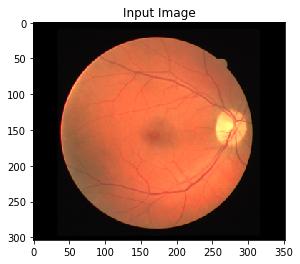

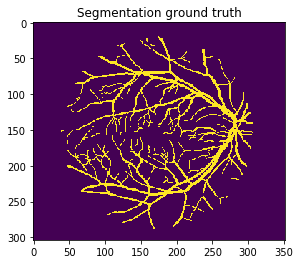

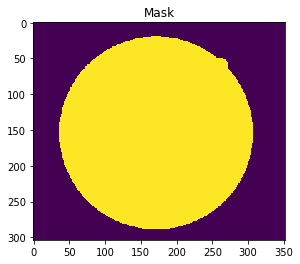

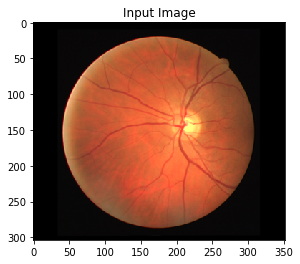

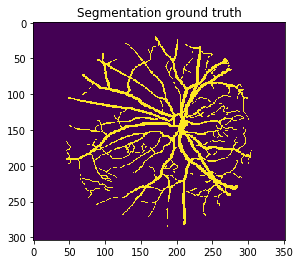

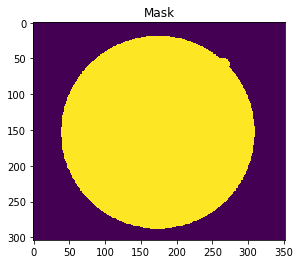

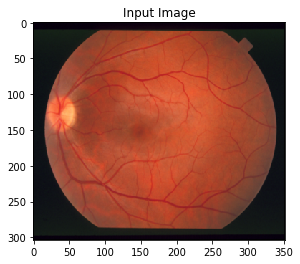

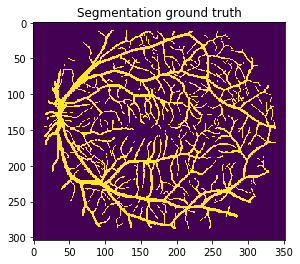

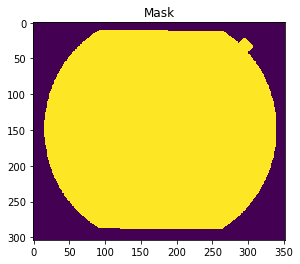

In [261]:
#Visualing a few cases in the training set
for batch_idx, (data, segmentation, mask) in enumerate( RetinaDataset(retina_array)):
    if batch_idx%15 == 0: 
        plt.figure()
        plt.title("Input Image")
        plt.imshow(data[:,:,:].permute([1,2,0]).cpu().numpy())
        plt.figure()
        plt.title("Segmentation ground truth")
        plt.imshow(segmentation[0,:,:].cpu().numpy())
        plt.figure()
        plt.title("Mask")
        plt.imshow(mask[0,:,:].cpu().numpy())
    

#### Defining a scoring function

To measure how good our segmentation results are, we are going to use the F1 score. This score is the harmonic mean between precision and recall, considering the foreground as the positive class and the background as the negative class. The score goes from 0 to 1, with 1 the best score possible. 

In [262]:
import sklearn

#use this function to score your models
def get_score_model(model, data_loader):
    #toggle model to eval mode
    model.eval()
    
    #turn off gradients since they will not be used here
    # this is to make the inference faster
    with torch.no_grad():
        logits_predicted = np.zeros([0, 1, 304, 352])
        segmentations = np.zeros([0, 1, 304, 352])
        #run through several batches, does inference for each and store inference results
        # and store both target labels and inferenced scores 
        for image, segmentation, mask  in data_loader:
            image = image.cuda()
            logit_predicted = model(image)
            logits_predicted = np.concatenate((logits_predicted, logit_predicted.cpu().detach().numpy()*mask.numpy()), axis = 0)
            segmentations = np.concatenate((segmentations, segmentation.cpu().detach().numpy()*mask.numpy()), axis = 0)   
    
    #returns a list of scores, one for each of the labels
    return sklearn.metrics.f1_score(segmentations.reshape([-1]), logits_predicted.reshape([-1])>0)

#### Q1 (13 points)
Justify why data augmentation usually helps in improving scores in deep learning tasks, and why horizontal flipping and vertical flipping make sense for this dataset. Would they both make sense in a natural image dataset? List at least one other kind of data augmentation that could also be applied for the retina blood vessels segmentation, and justify why.

<font color='blue'> 
    Deep learning models usually have a lot of hyperparameters that needs millions of labelled examples for supervised learning tasks. Labelled data is usually hard to obtain and therefore one cheap way to create diverse examples is to use different augmentation techniques - rotation, flipping, random cropping and scaling, changing color channels and addition of noise. 
    <br><br>
    The desired output of the images (ie the segmented ground truth) does not change when the image is flipped horizontally and vertically. Therefore for this task and this dataset, it makes sense to apply data augmentation. 
    <br><br>
    Now consider digit classification task over MNIST. The images with label 5 when flipped horizontally looks like 2 and so training flipped images with label 5 is going to confuse the CNN. Hence, it does not make sense to do data augmentation by flipping in MNIST.
    <br><br>
    For natural image dataset, we generally do not have mountain tops on the bottom of the image. So, it does not make sense for them to flip them vertically although horizontal flipping makes sense.
    <br><br>
    We could go for changing color as the augmentation technique since that does not change the segmented label and also such transformation is possible in real life because of imaging by different cameras.
</font>    

#### Q2 (11 points)
Check how balanced the dataset is, showing how many negative labels there are for each positive label. Use this information to change the weighting of the positive class in the loss for Question 3 and Question 5, and explain why in some cases using the weighting helps in improving performance.

In [263]:
positive_cnt = 0.0
negative_cnt = 0.0

# Iterate over the training set
for batch_idx, (data, segmentation, mask) in enumerate( RetinaDataset(retina_array)):
    segmented_img  = segmentation[0, :, :]
    mask_img       = mask[0, :, :]
    
    # Get an image where there are 3 labels - mask class (label -1 or -2), negative class (label 0) and positive class (label 1)
    new_img        = segmented_img - 2 * (1 - mask_img)
    
    positive_cnt   += torch.sum(new_img == 1)
    negative_cnt   += torch.sum(new_img == 0)
    
        
print("Positive (Foreground) Label Count   = {}".format(positive_cnt))
print("Negative (Background) Label Count   = {}".format(negative_cnt))
print("Ratio of Negative to Positive Label = {}".format(negative_cnt.type(torch.DoubleTensor)/positive_cnt))

Positive (Foreground) Label Count   = 492637
Negative (Background) Label Count   = 2180582
Ratio of Negative to Positive Label = 4.426346376743931


#### Q3 (45 points)
Build a u-net model class that inherits from the torch.nn.Module class. Follow the model as described in the original paper (https://arxiv.org/pdf/1505.04597.pdf - Fig. 1 and Section 2), but with these modifications chosen to simplify the assignment and to reduce memory use:
- Add 2D batch normalizations between convolutions and ReLUs.
- Add paddings to the convolutions so that the outputs of the convolutions have the same spatial size as the inputs. Because of this, the cropping before the concatenation of the skip connections is not necessary.
- The upsampling convolutions should be coded using the layer torch.nn.ConvTransposed2D. More details to understand what they meant in the paper can be found in the video here, starting at 2:22:  https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/
- Reduce the number of channels of all internal layers dividing them by 8. 
- Input should still have 3 channels, but output should have only one channel (binary output). 
- You can use PyTorch's weight initialization. You do not need to implement the initialization of weights as described in the u-net paper.

Use the masks provided with the dataset to mask your loss. Your loss should only backpropagate through the pixels where the mask has a value of 1, and not backpropagate where the mask is 0. Hyperparameters and methods to use are provided in the code cell below. Use the learning rate scheduler for training too. Your network should be able to get an F1 score of at least 0.75 in the validation set of the provided dataset, using the ``get_score_model`` function. Test your model on the test set.


In [264]:
from torchsummary import summary

########################################################################################
# Training function
########################################################################################
def train_model(model, criterion, optimizer, scheduler, device, train_loader, val_loader, epochs):
    
    # Transfer model and loss to the default device
    model     = model.to(device)
    criterion = criterion.to(device)

    for epoch in range(epochs):
        scheduler.step()
        
        # model for training
        model.train()
        train_losses = []

        for images, segment, mask in train_loader:        
            # Transfer variables to the default device
            images  = images.to(device)
            segment = segment.to(device)
            mask    = mask.to(device)
            
            # Clear optimizer of previous values
            optimizer.zero_grad()

            # Forward pass
            output = model(images)
            
            # Flatten the tensors
            input  = (output * mask).view(-1) 
            target = (segment* mask).view(-1)
            
            # Calculate loss    
            loss = criterion(input, target)
            loss.backward()

            optimizer.step()
            train_losses.append(loss.item())

        f1_score = get_score_model(model, val_loader)
        
        # Printing training loss after each epoch
        print("Epoch: {} Training_Loss: {:.6f} Validation_F1_Score: {:.3f}".format(epoch + 1, np.mean(train_losses), np.mean(f1_score)))


In [265]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


########################################################################################
# Parameters
########################################################################################
n_epochs = 200
workers  = 2


########################################################################################
# Get the datasplits in place
########################################################################################
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=6, shuffle=True,  num_workers=workers)
val_loader   = torch.utils.data.DataLoader(val_dataset,   batch_size=1, shuffle=False, num_workers=workers)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=1, shuffle=False, num_workers=workers)

cuda


In [266]:
import torch.nn as nn

# Architecture of UNet available at Fig 1, page 2 of https://arxiv.org/pdf/1505.04597.pdf
# More details to understand what they meant in the paper can be found in the video here, 
# starting at 2:22: https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/
#
# Added 2D batch normalizations between convolutions and ReLUs.
#
# Reduce the number of channels of all internal layers dividing them by 8.
#
# Added paddings to the convolutions so that the outputs of the convolutions have the same spatial size as 
# the inputs. Because of this, the cropping before the concatenation of the skip connections is not necessary.
#
# Input should still have 3 channels, but output should have only one channel (binary output).
# The upsampling convolutions should be coded using the layer torch.nn.ConvTransposed2D.

def pair_conv_layer(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1),
        torch.nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1),
        torch.nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )


# Sequential doesnot work because we have concatentation happening in U-Net
# Reference -
# https://github.com/usuyama/pytorch-unet/blob/master/pytorch_unet.py
#
# Transpose is learning parameter while Up-sampling is no-learning parameters. 
# https://discuss.pytorch.org/t/torch-nn-convtranspose2d-vs-torch-nn-upsample/30574/5
#
# https://pytorch.org/docs/stable/nn.html#torch.nn.ConvTranspose2d
# Hout=(Hin−1)×stride[0]−2×padding[0]+kernel_size[0]+output_padding[0]
# Hout is twice the Hin
# Choose stride[0]= 2 
# kernel_size[0] = 2
# padding[0] = 0
# output_padding[0] = 0
class UNet(nn.Module):
    def __init__(self, initialize = False,n_class = 1):
        super().__init__()
        self.conv_down1 = pair_conv_layer   (3 , 8)
        self.maxpool1   = nn.MaxPool2d      (kernel_size = 2, stride = 2)
        
        self.conv_down2 = pair_conv_layer   (8 , 16)
        self.maxpool2   = nn.MaxPool2d      (kernel_size = 2, stride = 2)
        
        self.conv_down3 = pair_conv_layer   (16, 32)
        self.maxpool3   = nn.MaxPool2d      (kernel_size = 2, stride = 2)
        
        self.conv_down4 = pair_conv_layer   (32, 64)        
        self.maxpool4   = nn.MaxPool2d      (kernel_size = 2, stride = 2)        
        
        self.conv_down5 = pair_conv_layer   (64, 128)
        
        self.upsample1  = nn.ConvTranspose2d(128, 128, kernel_size = 2, stride = 2, padding = 0)        
        self.conv_up1   = pair_conv_layer   (64 + 128, 64)
        
        self.upsample2  = nn.ConvTranspose2d(64,   64, kernel_size = 2, stride = 2, padding = 0)
        self.conv_up2   = pair_conv_layer   (32 +  64, 32)
        
        self.upsample3  = nn.ConvTranspose2d(32,   32, kernel_size = 2, stride = 2, padding = 0)
        self.conv_up3   = pair_conv_layer   (16 +  32, 16)
        
        self.upsample4  = nn.ConvTranspose2d(16,   16, kernel_size = 2, stride = 2, padding = 0)
        self.conv_up4   = pair_conv_layer   ( 8 +  16, 8)
        
        self.conv_last  = nn.Conv2d(8, 1, kernel_size = 1)
        self.sig    = nn.Sigmoid()
        
        if (initialize):
            print("Initializing modules by Kaiming initialization ...")
            for m in self.modules():
                if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
                    nn.init.kaiming_normal_(m.weight.data)
                    m.bias.data.fill_(0.0)
        else:
            print("Default initialization ...")
        
        
    def forward(self, x):
        # different variable for since they will be used
        down1 = self.conv_down1(x)
        x     = self.maxpool1  (down1)

        down2 = self.conv_down2(x)
        x     = self.maxpool2  (down2)
        
        down3 = self.conv_down3(x)
        x     = self.maxpool3  (down3)   
        
        down4 = self.conv_down4(x)
        x     = self.maxpool4  (down4)
        
        x     = self.conv_down5(x)
        
        x     = self.upsample1 (x)        
        x     = torch.cat([x, down4], dim=1)        
        x     = self.conv_up1  (x)
        
        x     = self.upsample2 (x)
        x     = torch.cat([x, down3], dim=1)        
        x     = self.conv_up2  (x)

        x     = self.upsample3 (x)
        x     = torch.cat([x, down2], dim=1)        
        x     = self.conv_up3  (x)

        x     = self.upsample4 (x)
        x     = torch.cat([x, down1], dim=1)        
        x     = self.conv_up4  (x)
        
        out   = self.conv_last (x)
        # The evaluation function does not need sigmoided output to evaluate. It checks for value > 0 
        # or equivalently p > 0.5 
        # out   = self.sig       (out)
        
        return out

In [267]:
########################################################################################
# Get the model in place with Kaiming initialization
########################################################################################
model = UNet(initialize = True)


########################################################################################
# Get the optimizers and schedulers in place
########################################################################################
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)

# Learning rate is reduced after plateauing to stabilize the end of training.
# use the learning rate scheduler as defined here. Example on how to integrate it to training in
# https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.StepLR
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=150, gamma=0.1)


########################################################################################
# Get the loss function in place
########################################################################################
# Reference
# https://pytorch.org/docs/stable/nn.html#torch.nn.BCEWithLogitsLoss
# If a dataset contains 100 positive and 300 negative examples of a single class, then 
# pos_weight for the class should be equal to \frac{300}{100} = 3. The loss would act 
# as if the dataset contains 3×100=300 positive examples.

#weight     = torch.Tensor([1., 1.])
weight     = negative_cnt.type(torch.DoubleTensor)/positive_cnt
criterion  = nn.BCEWithLogitsLoss(pos_weight = weight)

train_model(model, criterion, optimizer, scheduler, device, train_loader, val_loader, n_epochs)

Initializing modules by Kaiming initialization ...
Epoch: 1 Training_Loss: 0.958380 Validation_F1_Score: 0.296
Epoch: 2 Training_Loss: 0.955468 Validation_F1_Score: 0.281
Epoch: 3 Training_Loss: 0.953135 Validation_F1_Score: 0.272
Epoch: 4 Training_Loss: 0.950692 Validation_F1_Score: 0.294
Epoch: 5 Training_Loss: 0.947903 Validation_F1_Score: 0.325
Epoch: 6 Training_Loss: 0.942812 Validation_F1_Score: 0.346
Epoch: 7 Training_Loss: 0.933551 Validation_F1_Score: 0.366
Epoch: 8 Training_Loss: 0.923013 Validation_F1_Score: 0.394
Epoch: 9 Training_Loss: 0.908062 Validation_F1_Score: 0.427
Epoch: 10 Training_Loss: 0.899782 Validation_F1_Score: 0.434
Epoch: 11 Training_Loss: 0.883038 Validation_F1_Score: 0.517
Epoch: 12 Training_Loss: 0.868475 Validation_F1_Score: 0.516
Epoch: 13 Training_Loss: 0.855803 Validation_F1_Score: 0.570
Epoch: 14 Training_Loss: 0.836562 Validation_F1_Score: 0.468
Epoch: 15 Training_Loss: 0.824325 Validation_F1_Score: 0.474
Epoch: 16 Training_Loss: 0.805108 Validatio

Epoch: 135 Training_Loss: 0.599195 Validation_F1_Score: 0.727
Epoch: 136 Training_Loss: 0.597915 Validation_F1_Score: 0.735
Epoch: 137 Training_Loss: 0.598466 Validation_F1_Score: 0.739
Epoch: 138 Training_Loss: 0.597138 Validation_F1_Score: 0.731
Epoch: 139 Training_Loss: 0.599038 Validation_F1_Score: 0.731
Epoch: 140 Training_Loss: 0.596584 Validation_F1_Score: 0.728
Epoch: 141 Training_Loss: 0.598295 Validation_F1_Score: 0.735
Epoch: 142 Training_Loss: 0.598128 Validation_F1_Score: 0.730
Epoch: 143 Training_Loss: 0.597902 Validation_F1_Score: 0.732
Epoch: 144 Training_Loss: 0.597307 Validation_F1_Score: 0.730
Epoch: 145 Training_Loss: 0.599878 Validation_F1_Score: 0.734
Epoch: 146 Training_Loss: 0.597553 Validation_F1_Score: 0.734
Epoch: 147 Training_Loss: 0.596815 Validation_F1_Score: 0.735
Epoch: 148 Training_Loss: 0.594752 Validation_F1_Score: 0.741
Epoch: 149 Training_Loss: 0.594395 Validation_F1_Score: 0.733
Epoch: 150 Training_Loss: 0.594837 Validation_F1_Score: 0.731
Epoch: 1

In [274]:
########################################################################################
# Get the model in place using default initialization
########################################################################################
model = UNet(initialize = False)


########################################################################################
# Get the optimizers and schedulers in place
########################################################################################
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)

# Learning rate is reduced after plateauing to stabilize the end of training.
# use the learning rate scheduler as defined here. Example on how to integrate it to training in
# https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.StepLR
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=150, gamma=0.1)


########################################################################################
# Get the loss function in place
########################################################################################
# Reference
# https://pytorch.org/docs/stable/nn.html#torch.nn.BCEWithLogitsLoss
# If a dataset contains 100 positive and 300 negative examples of a single class, then 
# pos_weight for the class should be equal to \frac{300}{100} = 3. The loss would act 
# as if the dataset contains 3×100 = 300 positive examples.

#weight     = torch.Tensor([1., 1.])
weight     = negative_cnt.type(torch.DoubleTensor)/positive_cnt
criterion  = nn.BCEWithLogitsLoss(pos_weight = weight)

train_model(model, criterion, optimizer, scheduler, device, train_loader, val_loader, n_epochs)

Default initialization ...
Epoch: 1 Training_Loss: 0.974838 Validation_F1_Score: 0.000


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch: 2 Training_Loss: 0.963556 Validation_F1_Score: 0.000
Epoch: 3 Training_Loss: 0.956985 Validation_F1_Score: 0.000
Epoch: 4 Training_Loss: 0.954110 Validation_F1_Score: 0.000
Epoch: 5 Training_Loss: 0.952403 Validation_F1_Score: 0.000
Epoch: 6 Training_Loss: 0.951974 Validation_F1_Score: 0.002
Epoch: 7 Training_Loss: 0.950930 Validation_F1_Score: 0.229
Epoch: 8 Training_Loss: 0.950674 Validation_F1_Score: 0.310
Epoch: 9 Training_Loss: 0.950313 Validation_F1_Score: 0.329
Epoch: 10 Training_Loss: 0.949820 Validation_F1_Score: 0.332
Epoch: 11 Training_Loss: 0.949123 Validation_F1_Score: 0.336
Epoch: 12 Training_Loss: 0.948900 Validation_F1_Score: 0.338
Epoch: 13 Training_Loss: 0.947780 Validation_F1_Score: 0.340
Epoch: 14 Training_Loss: 0.946723 Validation_F1_Score: 0.345
Epoch: 15 Training_Loss: 0.942981 Validation_F1_Score: 0.359
Epoch: 16 Training_Loss: 0.939378 Validation_F1_Score: 0.355
Epoch: 17 Training_Loss: 0.931100 Validation_F1_Score: 0.355
Epoch: 18 Training_Loss: 0.91668

Epoch: 136 Training_Loss: 0.544127 Validation_F1_Score: 0.780
Epoch: 137 Training_Loss: 0.545365 Validation_F1_Score: 0.767
Epoch: 138 Training_Loss: 0.541437 Validation_F1_Score: 0.708
Epoch: 139 Training_Loss: 0.541731 Validation_F1_Score: 0.726
Epoch: 140 Training_Loss: 0.540338 Validation_F1_Score: 0.756
Epoch: 141 Training_Loss: 0.541134 Validation_F1_Score: 0.768
Epoch: 142 Training_Loss: 0.538524 Validation_F1_Score: 0.771
Epoch: 143 Training_Loss: 0.539832 Validation_F1_Score: 0.753
Epoch: 144 Training_Loss: 0.539553 Validation_F1_Score: 0.741
Epoch: 145 Training_Loss: 0.537805 Validation_F1_Score: 0.745
Epoch: 146 Training_Loss: 0.539799 Validation_F1_Score: 0.751
Epoch: 147 Training_Loss: 0.538096 Validation_F1_Score: 0.707
Epoch: 148 Training_Loss: 0.540613 Validation_F1_Score: 0.747
Epoch: 149 Training_Loss: 0.539156 Validation_F1_Score: 0.739
Epoch: 150 Training_Loss: 0.535616 Validation_F1_Score: 0.714
Epoch: 151 Training_Loss: 0.537642 Validation_F1_Score: 0.754
Epoch: 1

| Initialization | Validation F1_Score
|----------------| -------------------|
|   Kaiming | 0.733 |
|   Default | 0.761 |
<font color = blue>
 We conclude that the network when initialized with default (Xavier) initialization converges better.
</font>

In [275]:
########################################################################################
# Get the test set accuracy
########################################################################################
f1_score = get_score_model(model, test_loader)
print("Test score = {}".format(f1_score))

Test score = 0.7501345078264787


#### Q4 (8 points)
Visualize a few outputs of your network in the validation set and compare with your ground truth. Comment on the kinds of mistakes that you are able to distinguish.

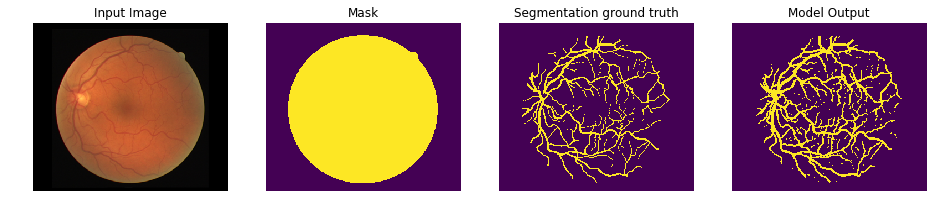

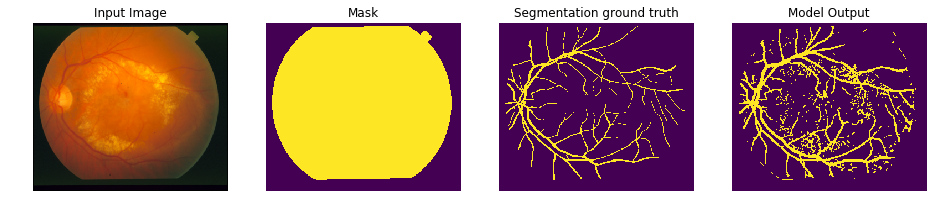

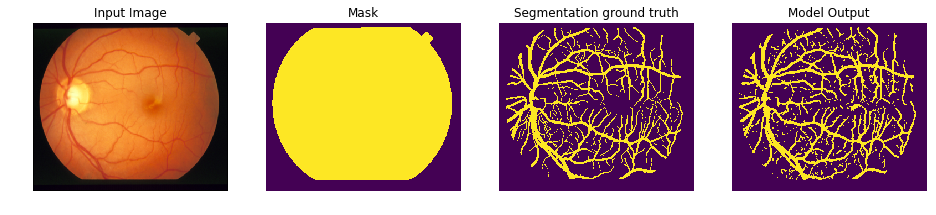

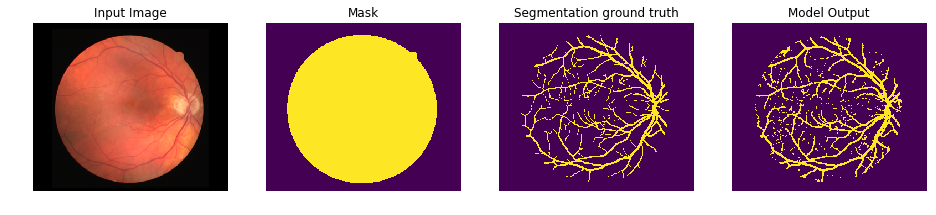

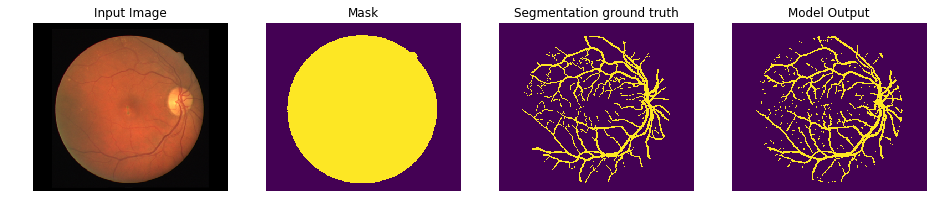

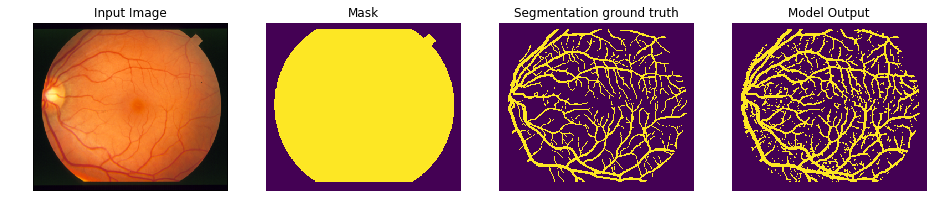

In [276]:
# function to get the outputs of the model in a numpy array
def get_output(model, data_loader):
    #toggle model to eval mode
    model.eval()
    
    #turn off gradients since they will not be used here
    # this is to make the inference faster
    with torch.no_grad():
        logits_predicted = np.zeros([0, 1, 304, 352])
        segmentations = np.zeros([0, 1, 304, 352])
        #run through several batches, does inference for each and store inference results
        # and store both target labels and inferenced scores 
        for image, segmentation, mask  in data_loader:
            image = image.cuda()
            logit_predicted = model(image)
            logits_predicted = np.concatenate((logits_predicted, logit_predicted.cpu().detach().numpy()*mask.numpy()), axis = 0)
            segmentations = np.concatenate((segmentations, segmentation.cpu().detach().numpy()*mask.numpy()), axis = 0)   

    logits_predicted[logits_predicted >= 0] = 1
    logits_predicted[logits_predicted <  0] = 0
    
    return logits_predicted



outputs = get_output(model, val_loader)

#Visualing a few cases in the validation set
for batch_idx, (data, segmentation, mask) in enumerate( RetinaDataset(retina_array, split='val')):
    if batch_idx%1 == 0: 
        plt.figure(figsize=(16, 12))
        plt.subplot(1, 4, 1)
        plt.title("Input Image")
        plt.imshow(data[:,:,:].permute([1,2,0]).cpu().numpy())
        plt.axis('off')
        plt.subplot(1, 4, 2)
        plt.title("Mask")
        plt.imshow(mask[0,:,:].cpu().numpy())
        plt.axis('off')
        plt.subplot(1, 4, 3)
        plt.title("Segmentation ground truth")
        plt.imshow(segmentation[0,:,:].cpu().numpy())
        plt.axis('off')
        plt.subplot(1, 4, 4)
        plt.title("Model Output")
        plt.imshow(outputs[batch_idx,0,:,:]*mask[0,:,:].cpu().numpy())
        plt.axis('off')

<font color="blue">
       The lines are found to be in general thicker than the ground truth. It also fails for lines which are very thin. The model output is more noisy than the ground truth.
</font>

#### Q5 (23 points)
Modify your u-net module to receive a boolean argument in initialization/contruction that can deactivate the use of the skip connections. To compensate for not having the extra channels coming from the skip connection, you should double the number of channels out of the upsampling layer when skip connections are deactivated. Train and test the network without the skip connections, using the hyperparameters as provided in the cell below. You should be able to get an F1 score of at least 0.5.  When compared to the network trained on Question 3, which network performs better? Explain why that happens, detailing the role of the skip connections for a segmentation task. Link your explanations to visualizations of the output of the network without skip connections.

In [277]:
########################################################################################
# Parameters
########################################################################################
n_epochs = 200
workers  = 2


########################################################################################
# Get the datasplits in place
########################################################################################
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=6, shuffle=True,  num_workers=workers)
val_loader   = torch.utils.data.DataLoader(val_dataset,   batch_size=1, shuffle=False, num_workers=workers)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=1, shuffle=False, num_workers=workers)

In [278]:
import torch.nn as nn

# Architecture of UNet available at Fig 1, page 2 of https://arxiv.org/pdf/1505.04597.pdf
# More details to understand what they meant in the paper can be found in the video here, 
# starting at 2:22: https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/
#
# Added 2D batch normalizations between convolutions and ReLUs.
#
# Reduce the number of channels of all internal layers dividing them by 8.
#
# Added paddings to the convolutions so that the outputs of the convolutions have the same spatial size as 
# the inputs. Because of this, the cropping before the concatenation of the skip connections is not necessary.
#
# Input should still have 3 channels, but output should have only one channel (binary output).
# The upsampling convolutions should be coded using the layer torch.nn.ConvTransposed2D.

def pair_conv_layer(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1),
        torch.nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1),
        torch.nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )


# Sequential doesnot work because we have concatentation happening in U-Net
# Reference -
# https://github.com/usuyama/pytorch-unet/blob/master/pytorch_unet.py
#
# Transpose is learning parameter while Up-sampling is no-learning parameters. 
# https://discuss.pytorch.org/t/torch-nn-convtranspose2d-vs-torch-nn-upsample/30574/5
#
# https://pytorch.org/docs/stable/nn.html#torch.nn.ConvTranspose2d
# Hout=(Hin−1)×stride[0]−2×padding[0]+kernel_size[0]+output_padding[0]
# Hout is twice the Hin
# Choose stride[0]= 2 
# kernel_size[0] = 2
# padding[0] = 0
# output_padding[0] = 0
class UNet_Modified(nn.Module):
    def __init__(self, initialize = False, deactivate_skip = False, n_class = 1):
        super().__init__()
        self.conv_down1 = pair_conv_layer   (3 , 8)
        self.maxpool1   = nn.MaxPool2d      (kernel_size = 2, stride = 2)
        
        self.conv_down2 = pair_conv_layer   (8 , 16)
        self.maxpool2   = nn.MaxPool2d      (kernel_size = 2, stride = 2)
        
        self.conv_down3 = pair_conv_layer   (16, 32)
        self.maxpool3   = nn.MaxPool2d      (kernel_size = 2, stride = 2)
        
        self.conv_down4 = pair_conv_layer   (32, 64)        
        self.maxpool4   = nn.MaxPool2d      (kernel_size = 2, stride = 2)        
        
        self.conv_down5 = pair_conv_layer   (64, 128)
                
        self.deactivate_skip = deactivate_skip
        
        if(deactivate_skip):
            print("\nSkip connections deactivated ...")
            print("To compensate for not having the extra channels coming from the skip connection, doubling "
                  "the number of channels out of the upsampling layer.")
        
        
        if (deactivate_skip):
            self.upsample1  = nn.ConvTranspose2d(128, 256, kernel_size = 2, stride = 2, padding = 0)        
            self.conv_up1   = pair_conv_layer   (256, 64)
        else:
            self.upsample1  = nn.ConvTranspose2d(128, 128, kernel_size = 2, stride = 2, padding = 0)        
            self.conv_up1   = pair_conv_layer   (64 + 128, 64)
        
        if (deactivate_skip):
            self.upsample2  = nn.ConvTranspose2d(64, 128, kernel_size = 2, stride = 2, padding = 0)
            self.conv_up2   = pair_conv_layer   (128, 32)
        else:
            self.upsample2  = nn.ConvTranspose2d(64,   64, kernel_size = 2, stride = 2, padding = 0)
            self.conv_up2   = pair_conv_layer   (32 +  64, 32)
        
        if (deactivate_skip):
            self.upsample3  = nn.ConvTranspose2d(32, 64, kernel_size = 2, stride = 2, padding = 0)
            self.conv_up3   = pair_conv_layer   (64, 16)
        else:
            self.upsample3  = nn.ConvTranspose2d(32,   32, kernel_size = 2, stride = 2, padding = 0)
            self.conv_up3   = pair_conv_layer   (16 +  32, 16)
        
        if (deactivate_skip):
            self.upsample4  = nn.ConvTranspose2d(16,   32, kernel_size = 2, stride = 2, padding = 0)
            self.conv_up4   = pair_conv_layer   (32, 8)
        else:
            self.upsample4  = nn.ConvTranspose2d(16,   16, kernel_size = 2, stride = 2, padding = 0)
            self.conv_up4   = pair_conv_layer   ( 8 +  16, 8)
        
        self.conv_last  = nn.Conv2d(8, 1, kernel_size = 1)
        
        if (initialize):
            print("Initializing modules by Kaiming initialization ...")
            for m in self.modules():
                if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
                    nn.init.kaiming_normal_(m.weight.data)
                    m.bias.data.fill_(0.0)
        else:
            print("Default initialization ...")
        
        
    def forward(self, x):
        
        # different variable for since they will be used
        down1 = self.conv_down1(x)
        x     = self.maxpool1  (down1)

        down2 = self.conv_down2(x)
        x     = self.maxpool2  (down2)
        
        down3 = self.conv_down3(x)
        x     = self.maxpool3  (down3)   
        
        down4 = self.conv_down4(x)
        x     = self.maxpool4  (down4)
        
        x     = self.conv_down5(x)
        
        x     = self.upsample1 (x)
        if(not self.deactivate_skip):
            x = torch.cat([x, down4], dim=1)        
        x     = self.conv_up1  (x)
        
        x     = self.upsample2 (x)
        if(not self.deactivate_skip):
            x = torch.cat([x, down3], dim=1)        
        x     = self.conv_up2  (x)

        x     = self.upsample3 (x)
        if(not self.deactivate_skip):
            x = torch.cat([x, down2], dim=1)        
        x     = self.conv_up3  (x)

        x     = self.upsample4 (x)
        if(not self.deactivate_skip):
            x = torch.cat([x, down1], dim=1)        
        x     = self.conv_up4  (x)
        
        out   = self.conv_last (x)
        # The evaluation function does not need sigmoided output to evaluate. It checks for value > 0 
        # or equivalently p > 0.5 
        # out   = self.sig       (out)
        
        return out

In [281]:
########################################################################################
# Get the model in place using default initialization and deactivating skip connections
########################################################################################
model2 = UNet_Modified(initialize = False, deactivate_skip = True)


########################################################################################
# Get the optimizers and schedulers in place
########################################################################################
optimizer = torch.optim.SGD(model2.parameters(), lr=0.01, momentum=0.9, nesterov=True)

# Learning rate is reduced after plateauing to stabilize the end of training.
# use the learning rate scheduler as defined here. Example on how to integrate it to training in
# https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.StepLR
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=150, gamma=0.1)


########################################################################################
# Get the loss function in place
########################################################################################
# Reference
# https://pytorch.org/docs/stable/nn.html#torch.nn.BCEWithLogitsLoss
# If a dataset contains 100 positive and 300 negative examples of a single class, then 
# pos_weight for the class should be equal to \frac{300}{100} = 3. The loss would act 
# as if the dataset contains 3×100=300 positive examples.

weight     = negative_cnt.type(torch.DoubleTensor)/positive_cnt
criterion  = nn.BCEWithLogitsLoss(pos_weight = weight)


# train your model here:
train_model(model2, criterion, optimizer, scheduler, device, train_loader, val_loader, n_epochs)


Skip connections deactivated ...
To compensate for not having the extra channels coming from the skip connection, doubling the number of channels out of the upsampling layer.
Default initialization ...
Epoch: 1 Training_Loss: 0.960832 Validation_F1_Score: 0.000


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch: 2 Training_Loss: 0.956712 Validation_F1_Score: 0.000
Epoch: 3 Training_Loss: 0.954847 Validation_F1_Score: 0.000
Epoch: 4 Training_Loss: 0.953938 Validation_F1_Score: 0.000
Epoch: 5 Training_Loss: 0.953754 Validation_F1_Score: 0.000
Epoch: 6 Training_Loss: 0.953512 Validation_F1_Score: 0.000
Epoch: 7 Training_Loss: 0.952733 Validation_F1_Score: 0.017
Epoch: 8 Training_Loss: 0.952296 Validation_F1_Score: 0.077
Epoch: 9 Training_Loss: 0.950710 Validation_F1_Score: 0.186
Epoch: 10 Training_Loss: 0.949385 Validation_F1_Score: 0.301
Epoch: 11 Training_Loss: 0.947799 Validation_F1_Score: 0.326
Epoch: 12 Training_Loss: 0.944558 Validation_F1_Score: 0.341
Epoch: 13 Training_Loss: 0.942431 Validation_F1_Score: 0.339
Epoch: 14 Training_Loss: 0.940019 Validation_F1_Score: 0.351
Epoch: 15 Training_Loss: 0.937614 Validation_F1_Score: 0.349
Epoch: 16 Training_Loss: 0.935575 Validation_F1_Score: 0.350
Epoch: 17 Training_Loss: 0.930667 Validation_F1_Score: 0.366
Epoch: 18 Training_Loss: 0.92753

Epoch: 136 Training_Loss: 0.752525 Validation_F1_Score: 0.551
Epoch: 137 Training_Loss: 0.756362 Validation_F1_Score: 0.555
Epoch: 138 Training_Loss: 0.752213 Validation_F1_Score: 0.541
Epoch: 139 Training_Loss: 0.750824 Validation_F1_Score: 0.541
Epoch: 140 Training_Loss: 0.749395 Validation_F1_Score: 0.555
Epoch: 141 Training_Loss: 0.746114 Validation_F1_Score: 0.528
Epoch: 142 Training_Loss: 0.750191 Validation_F1_Score: 0.530
Epoch: 143 Training_Loss: 0.748789 Validation_F1_Score: 0.547
Epoch: 144 Training_Loss: 0.746751 Validation_F1_Score: 0.540
Epoch: 145 Training_Loss: 0.745564 Validation_F1_Score: 0.559
Epoch: 146 Training_Loss: 0.746851 Validation_F1_Score: 0.556
Epoch: 147 Training_Loss: 0.747517 Validation_F1_Score: 0.518
Epoch: 148 Training_Loss: 0.739682 Validation_F1_Score: 0.529
Epoch: 149 Training_Loss: 0.744479 Validation_F1_Score: 0.540
Epoch: 150 Training_Loss: 0.745491 Validation_F1_Score: 0.519
Epoch: 151 Training_Loss: 0.739077 Validation_F1_Score: 0.542
Epoch: 1

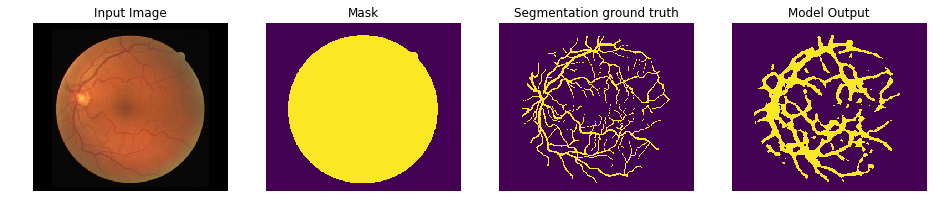

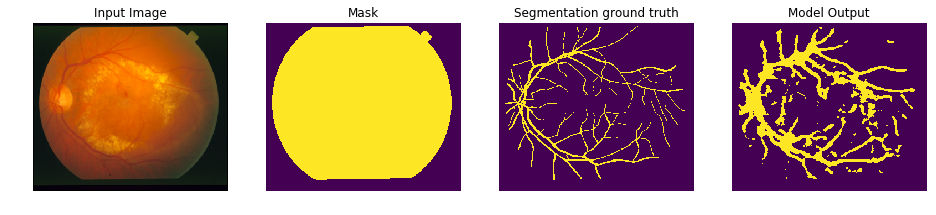

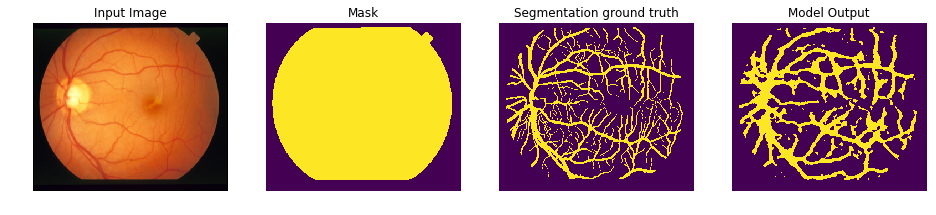

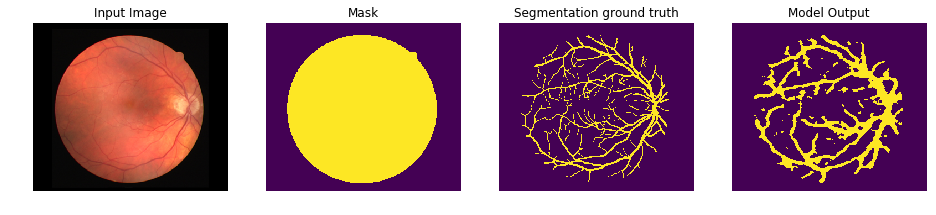

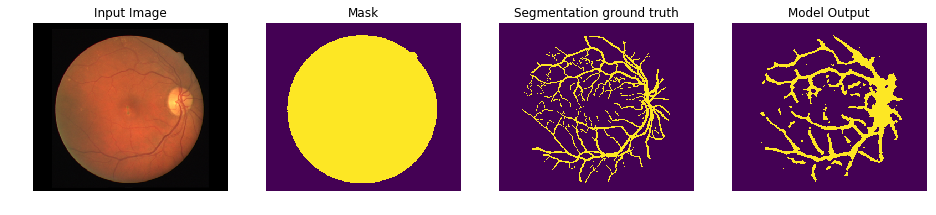

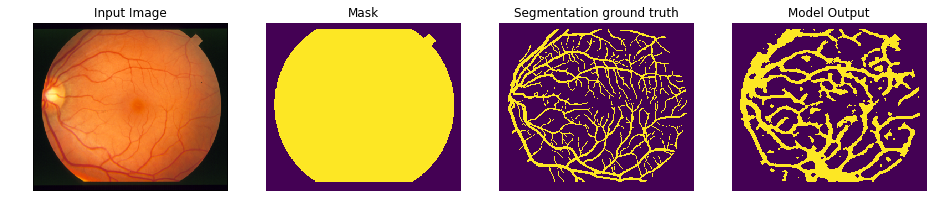

In [282]:
outputs = get_output(model2, val_loader)

#Visualing a few cases in the validation set
for batch_idx, (data, segmentation, mask) in enumerate( RetinaDataset(retina_array, split='val')):
    if batch_idx%1 == 0: 
        plt.figure(figsize=(16, 12))
        plt.subplot(1, 4, 1)
        plt.title("Input Image")
        plt.imshow(data[:,:,:].permute([1,2,0]).cpu().numpy())
        plt.axis('off')
        plt.subplot(1, 4, 2)
        plt.title("Mask")
        plt.imshow(mask[0,:,:].cpu().numpy())
        plt.axis('off')
        plt.subplot(1, 4, 3)
        plt.title("Segmentation ground truth")
        plt.imshow(segmentation[0,:,:].cpu().numpy())
        plt.axis('off')
        plt.subplot(1, 4, 4)
        plt.title("Model Output")
        plt.imshow(outputs[batch_idx,0,:,:]*mask[0,:,:].cpu().numpy())
        plt.axis('off')

| Model | Skip Connections |  Validation F1_Score
|------|------|-----|
|   Q3  | Present| 0.761 |
|   Q5  | Absent | 0.545 |
<font color = blue>
 The model in Q3 is better since it gives a better validation score.This is expected since because of the vanishing gradient problem, the gradients in the layers far off from the loss are diminishing and therefore the parameters do not get updated precisely. As a result, network cannnot output the results in a precise manner.
 
 <br><br>
 This is in agreement with the paper "The Importance of Skip Connections in Biomedical Image Segmentation" by Drozdza et al,  DLMIA 2016, available at https://arxiv.org/pdf/1608.04117.pdf. The authors say that 
parameter updates appear to be well distributed when short skip connections are present. When the short skip connections are removed, they find that for deep models, the deep parts of the network get few updates. 
</font>